Primero importamos los paquetes que necesitamos para el trabajo.

In [7]:
from numpy.random import default_rng as random_number_generator
from tp.schelling import mercado_inmobiliario
from tp.presentacion import (
    mostrar_texto, 
    generar_capital_inicial, 
    mostrar_satisfechos_antes_despues, 
    plot_satisfacciones_para_alpha,
    create_os_buttons,
    detect_os,
    opciones_ejecutar_modelo
)
from tp.definiciones import (
    gini, 
    criterio_equilibrio, 
    gini_barrio_k, 
    gini_barrio_u, 
    gini_total,
    satisfechos_en,
    observaciones_de,
    alpha_del_modelo,
    rango_del_modelo,
    gini_capital_modelo,
    gini_utilidad_modelo,
    gini_capital_por_barrio,
    gini_utilidad_por_barrio,
    satisfechos_por_barrio,
    cantidad_de_pasos,
    correr_modelo,
    generate_filename,
    non_colliding_name,
    Storage
)
from tp.util import Mapa, simulador, SimuladorFactory
import tp.util.json as json
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

---
---

# Schelling cambiando el rango de visión

## Introducción
El siguiente trabajo se basa en el modelo original de Schelling inmobiliario, un modelo de autómata celular. En este modelo tenemos 2 grupos distribuidos de manera aleatoria, donde cada agente busca estar junto con gente de su grupo. Definimos una función de utilidad por posición, la cual está dada por el capital (se le da mayor o menor importancia según una variable alpha) y el valor que el agente le asigna a la propiedad (que depende de la cantidad de vecinos iguales o distintos que tiene). Se eligen a 2 agentes de manera random (considerando todos los agentes) y solo intercambian posición si mejora la función de utilidad de ambos.

Al realizar ciertas modificaciones al modelo original, buscamos que se asemeje más a la realidad. Generalmente, cuando alguien se muda, no lo hace muy lejos de su lugar de residencia original, ya que no quiere cambiar de escuela, amigos, etc. Además, mudarse a otro barrio puede implicar distintos costos, dependiendo de cuál sea el barrio. Por lo tanto, a través de diversos experimentos, intentaremos responder a la siguiente pregunta: ¿Cómo varía la cantidad de satisfechos en el estado de equilibrio, si existe, en función de distintos rangos de visión, considerando diversos costos de mudanza y costo de propiedad según el barrio? 

Además, para poder responder a la pregunta anterior vimos el índice de Gini en cada uno de los experimentos variando diversos parámetros. REVISAR

Por lo tanto, debido a las modificaciones que le debemos hacer al modelo original para responder la pregunta en cuestión, en este caso, tendremos una grilla de tamaño L=50 donde a cada posición se le corresponde un barrio definido (cada barrio es un conjunto de casillas contiguas). De la misma manera que el modelo original, cada agente comenzará con cierto capital inicial que definiremos como hiperparámetro del modelo. Además, introducimos el concepto de “rango de visión”, que le dice a un agente qué tanto se puede mover dentro de la grilla. Este rango es un porcentaje del tamaño de la grilla L, es decir, si tiene un 0.5 de visión, entonces el agente considera mudarse a casillas que se encuentren dentro del 50% de la grilla alrededor de su posición. Por lo tanto, cada uno de los agentes va a tener la posibilidad de intercambiar posición con alguien dentro de su rango de visión. 

Además, introdujimos la modificación de que al mudarse a cierto barrio, hay un costo de mudanza específico para cada uno. Es intuitivo que en los barrios más caros sea más caro el costo de mudanza. Por lo tanto, esto va a afectar en la capacidad de mudarse de cada uno de los agentes, pues al considerar mudarse a otra posición se deberá tener en cuenta si tiene capital suficiente para el valor de la casa, el costo de mudanza y si le suma utilidad mudarse.

Para los experimentos, consideramos 4 barrios distintos posibles, con diferente precio de propiedades y mudanza. El barrio 1 es el más caro, y el barrio 4 el más barato.
| Barrio | Precio de mudanza | Precio de Propiedades | Color   |
|--------|-------------------|-----------------------|---------|
| 1      | 3.0               | 1.35                  | Rojo    |
| 2      | 2.25              | 1.0125                | Azul    |
| 3      | 1.2               | 0.54                  | Verde   |
| 4      | 0.15              | 0.0675                | Naranja |

Luego de probar varios valores posibles para los precios de mudanza y propiedades, elegimos los que daban resultados más interesantes.

Se realizaron varios experimentos con dos grillas distintas, una de cuatro cuadrantes (teniendo en cuenta los 4 barrios) y otra de tres tercios (teniendo en cuenta sólo 3). Para ambos, dejamos fijo un valor de alpha de entre los siguientes valores posibles:
* α = 0.1
* α = 0.4
* α = 0.8

Para cada uno de estos, se realizó un cambió en el rango de visión realizando 1000 iteraciones, es decir, creamos de forma equiespaciada 1000 valores entre 0 y 1. 
Además, se tuvieron en cuenta dos valores de configuración inicial máxima, es decir, start_max. Estos valores fueron 1 y 10. Los valores de las configuraciones iniciales para cada agente, se definieron de manera random con números elegidos de manera uniforme entre 0 y start_max.


Inicialicemos las variables con las que vamos a hacer los experimentos.

In [ ]:
N = 50 # Tamaño de la grilla

alphas = [
    .1,
    .4,
    .8   
]

subdivisiones = 100
rangos_de_vision = np.linspace(0,1, subdivisiones)


# Generador de numeros aleatorios para Numpy
rng = random_number_generator(seed=1)

---
## Grilla cuatro cuadrantes
Como primera distribución de barrios, tuvimos en cuenta una grilla que está separada por los 4 barrios de forma que se tienen cuatro cuadrantes del mismo tamaño. 



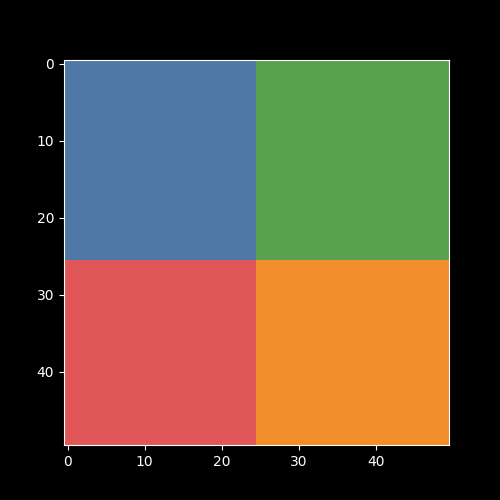

,Precio Propiedades,Precio Mudanza
Barrio 0,1.3500,3.00
Barrio 1,1.0125,2.25
Barrio 2,0.5400,1.20
Barrio 3,0.0675,0.15


In [2]:
cuatro_cuadrantes = Mapa.load('./tp/data/mapas/cuatro_cuadrantes.txt', barrios_definidos='./tp/data/mapas/barrios.json')

cuatro_cuadrantes.show()
cuatro_cuadrantes.barrios_info()

Podemos observar que, cómo dijimos antes, el barrio más caro es el rojo, luego el azul, verde y por último el más barato es el naranja.

## Grilla tercios

Por otro lado, tuvimos en cuenta una grilla que está separada por los primero 3 barrios de forma que se tienen tres tercios del mismo tamaño, dejándo afuera el último barrio (el más barato). 

In [ ]:
tercios = Mapa.load('./tp/data/mapas/tercios.txt', barrios_definidos='./tp/data/mapas/barrios.json')

tercios.show()
tercios.barrios_info()

### Veamos las condiciones iniciales para los experimentos

Seteamos una semilla para que todos los experimentos sean reproducibles.

In [3]:
rng = random_number_generator(seed=1)

In [4]:
config_grafica = {
    # Titulo de ambos graficos
    'suptitle': "Distribución del capital inicial\nmapa: 'cuatro_cuadrantes'",

    # Configuración gráfica del heatmap
    'cmap': 'inferno',

    # Configuración gráfica de Gini/Lorenz
    'color_linea': '#0055FF',
    'color_relleno': '#FF4A00',
    'titulo': 'Curva de Lorenz y Coeficiente de Gini\n\n',
    'subtitulo': 'Comparación entre la igualdad total (gini_index=1, linea de igualdad) y el índice de Gini real, calculado a partir de la distribución de capital inicial de los agentes.',
}

Veamos en detalle la configuración inicial que se usará en aquellos experimentos donde esta es una distribución uniforme entre 0 y 10. Además, observemos cómo se ve la curva de Lorenz y el Coeficiente de Gini con la configuración inicial.

<Figure size 640x480 with 0 Axes>

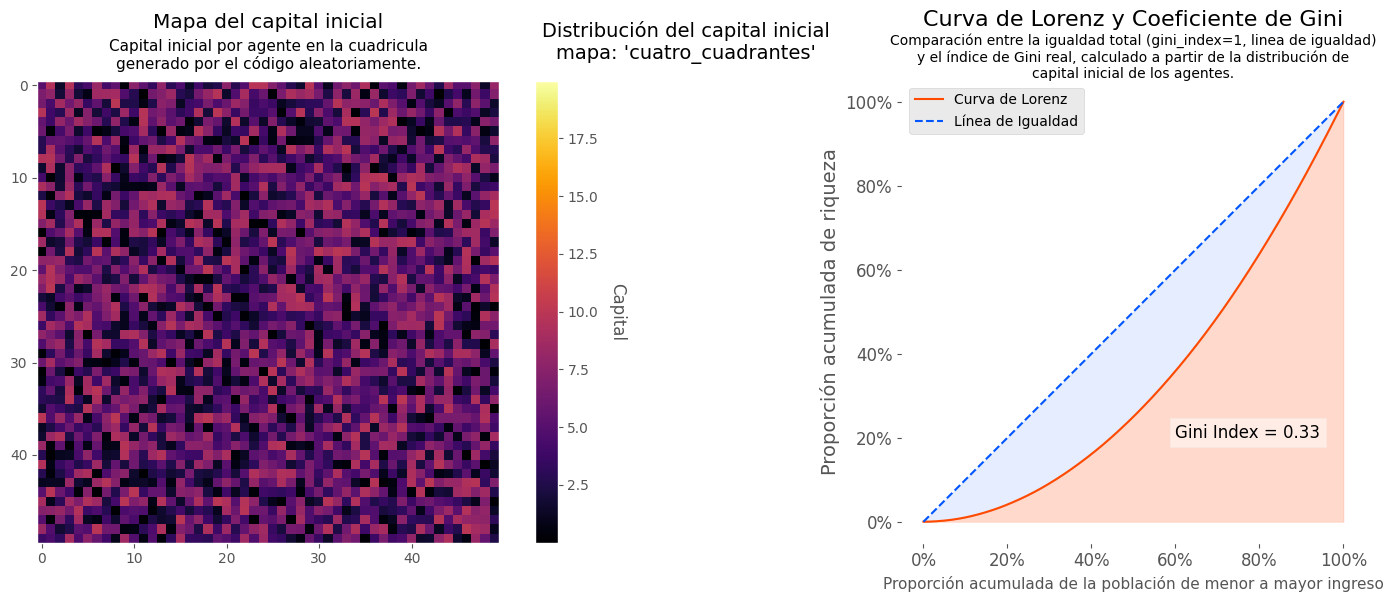

In [5]:
capital_inicial, escala, gini_k0 = \
    generar_capital_inicial(rng.uniform, low=0, high=10, 
                            size=cuatro_cuadrantes.mapa.shape, 
                            config_grafica=config_grafica)

# la linea de la igualdad no deberia ser gini=0?

Podemos observar como se ve una distrubución uniforme del capital en el mapa. En la barra de la derecha donde se ve el color dependiendo del capital, se puede ver que esta llega hasta un valor de 20 a pesar de que el capital inicial es hasta 10. Esto se debe a que cuando realicemos los experimentos, habrá agentes que aumenten su capital a más de 10 (ya que le sacan capital a otros agentes). Pusimos un valor de 20 ya que luego de realizar varias pruebas notamos que como máximo los agentes llegaban a tener este valor de capital.

Se puede observar que el valor de Gini inicial es de 0.33. 

## Experimentos

En esta sección nos centraremos en mostrar la satisfacción de los agentes al variar el rango de visión, además de tener en cuenta distintos $\alpha$, como también dos valores diferentes de capital inicial. Por otro lado, también nos pareció relevante mostrar el Índice de Gini pues nos da una mejor idea de cómo se distribuye el capital inicial bajo distintas condiciones.

Antes de realizar los experimentos, debemos generar los datos con los que los haremos. Para ello, realizamos 1000 iteraciones de  rangos de visión, es decir, creamos de forma equiespaciada 1000 valores entre 0 y 1. Además, esto lo debemos hacer para los 3 $\alpha$ mencionados anteriormente (0.1, 0.4, 0.8), los dos valores de capital inicial (1, 10), así como también para las dos grillas de barrios (tercios, cuadrantes).


In [22]:
#ACA IRÍA EL CODIGO QUE GENERA LOS DATOS CON LOS QUE SE REALIZARAN LOS GRAFICOS

### Satisfacción
En este caso separaremos los estudios basándonos en ambas grillas de barrios, la de cuadrantes y la de tercios.

#### Tercios

In [15]:
#CODIGO QUE GENERA LOS GRAFICOS

Observamos que a medida que aumenta el rango de visión, en ambos gráficos para el $\alpha$ = 0.1 se observa un crecimiento pronunciado de satisfechos, para luego estabilizarse. Sin embargo, a medida que aumenta el $\alpha$, este crecimiento es cada vez más pequeño. 
En el gráfico de start_max = 10, se tiene más riqueza para distribuir. Al valorarse más la riqueza, es decir, cuando el $\alpha$ crece, tiene sentido que el porcentaje de satisfechos sea mayor en comparación al gráfico de start_max = 1.


#### Cuadrantes

In [17]:
#CODIGO QUE GENERA LOS GRAFICOS

Vemos que la comparación es muy similar a la del mapa de tercios, pero el número en el que se estabiliza la curva de $\alpha$ = 0.1 es menor (aprox. 10%) en el caso de start_max = 10. En cambio, para start_max = 1, todas las curvas se estabilizan en un máximo de satisfechos menor.

### Satisfacción por barrio
Para el caso de la grilla de cuatro cuadrantes y capital inicial = 10, veamos cómo varía la satisfacción por barrio para los 3 valores de $\alpha$ elegidos.

In [18]:
# ACA IRIAN LOS 3 GRAFICOS UNO AL LADO DEL OTRO PARA MEJOR VISUALIZACION

Recordemos que si el $\alpha$ es:
* bajo: importa más el valor de la casa
* medio: importan por igual
* alto: importa más la riqueza
Un $\alpha$ grande significa que se prioriza más el capital.

En el primer caso, de $\alpha$ = 0.8, estamos poniendo como límite de capital muy alto y todos los agente priorizan mucho la riqueza. Podemos notar que en todos los barrios el porcentaje de satisfechos finales se encuentra entre 85% y 95% para todos los rangos de visión considerados. 

En el segundo gráfico, estamos poniendo un valor de $\alpha$ medio, 0.4. Por lo tanto, los agentes priorizan la riqueza y el valor de la casa casi de la misma forma (aunque priorizan un poquito más el valor de la casa). Podemos notar que para el rango de visión 0 (i.e. sin intercambios), todos los barrios comienzan con un porcentaje de satisfechos finales que ronda el 80%. Sin embargo, a medida que aumenta el rango de visión, se genera una leve diferencia entre los barrios 0 y 1 (barrios más caros), con los barrios 2 y 3 (barrios más baratos) en donde los primeros tienen un porcentaje de satisfechos mayor. 

Por último, en el gráfico de $\alpha$ = 0.1, notamos que se profundiza la diferencia entre los barrios más caros y los más baratos, los barrios más baratos son los que tienen menor porcentaje de satisfechos. Esto es consecuencia de que como el alpha es bajo nos importa más el valor de la casa, por lo tanto los agentes estarán dispuestos a comprar casas más caras, que son las que se encuentran en los barrios 0 y 1.

### Índice de Gini

Para este experimento, nos pareció adecuado realizar la experimentación separando en función del capital inicial. Primero, para un capital inicial = 1 y luego para uno = 10, realizando en cada caso los gráficos para las dos grillas de barrios que hay.

#### Capital Inicial = 1

In [20]:
# ACA VAN LOS GRAFICOS DE GINI DE CAPITAL INICIAL = 1, DE CUADRANTES Y TERCIOS

Vemos que en ambos gráficos en los rangos de visión iniciales para $\alpha$ = 0.1 crece el índice de Gini más que para los otros dos. A medida que aumenta el $\alpha$, baja el índice de Gini, lo cual nos dice que hay menos desigualdad de capital en la población. Sin embargo, a medida que aumenta el rango de visión todos se estabilizan al llegar a un rango de visión de aproximadamente en un 10% del rango de visión más grande. Sin embargo, el rango en el que observamos el índice de Gini es muy pequeño (con la mayor diferencia siendo alrededor de 0.03 en ambos gráficos), por lo que se podría decir que no hay mucha variación de índice de Gini entre $\alpha$ cuando el capital inicial máximo es 1 ni tampoco cuando variamos la configuración de los barrios


#### Capital Inicial = 10

In [21]:
# ACA VAN LOS GRAFICOS DE GINI DE CAPITAL INICIAL = 10, DE CUADRANTES Y TERCIOS

Podemos observar que en ambos gráficos a medida que aumenta el rango de visión, el índice de Gini aumenta rápidamente para todos los $\alpha$ hasta que se estabiliza. Para el $\alpha$ = 0.8 el aumento de Gini es mucho más pronunciado al comienzo en ambos gráficos, en comparación con los otros dos $\alpha$. 

Por otro lado, al comparar ambos gráficos vemos que la configuración inicial de barrios es importante al momento de estudiar el efecto que tiene el cambio de $\alpha$ en el índice de Gini. Para los $\alpha$ más grandes, en nuestro caso $\alpha$ = 0.8, se ve que en el mapa de tercios la tendencia llega a un punto máximo de Gini y luego disminuye mucho más que en el mapa de cuartos, ya que en este último el índice de Gini supera al de $\alpha$ = 0.4, mentiras que en el mapa de tercios el de $\alpha$ = 0.4 es mayor al momento de estabilizarse.


## Conclusiones

## Apéndice

En esta sección agregamos algunas conclusiones que nos pareció relevante mencionar, pero no llegaron a quedar en el trabajo principal.

### Pasos hasta estabilizarse

Nos pareció interesante analizar la cantidad de pasos que pasan hasta que el sistema se estabiliza, si es que esto sucede, según la grilla de barrios que se utiliza.

---

In [6]:
mediciones = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
    gini_total,
    *(gini_barrio_k(x) for x in cuatro_cuadrantes.barrios),
    *(gini_barrio_u(x) for x in cuatro_cuadrantes.barrios),
    *(satisfechos_en(x) for x in cuatro_cuadrantes.barrios),
)

In [7]:
parametros_modelo = {
    'alpha': .8,
    'rango_de_vision': 0.15,
}

In [8]:
modelo = mercado_inmobiliario(
    mapa = cuatro_cuadrantes,
    rng = rng,
    capital_inicial=capital_inicial,
    **parametros_modelo
)

sim = simulador(modelo, 
               criterio_equilibrio, 
               max_steps=int(1e3), 
               lag=20, 
               tol=1e-3, 
               cache_actions=mediciones)

In [9]:
satisfechos_inicial = modelo.lattice()
sim.run()
satisfechos_final = modelo.lattice()

/home/joan.new/remote/personal/msscae-tp/src/tp/definiciones.py:74: UserWarning: Aplanando la matriz para calcular el coeficiente de Gini.
  warnings.warn("Aplanando la matriz para calcular el coeficiente de Gini.")


La simulación alcanzó el equilibrio en 478 pasos.


In [10]:
opciones_graficas_antes_despues_cuatro_cuadrantes = {
    'scale': 5,
    'suptitle': "Satisfacción de los agentes - mapa: 'cuatro_cuadrantes'"+'\n'*5,
    'subtitulo': "Calculado a través de la utilidad de cada agente en la cuadrícula.\n" +'Sitios naranjas y amarillos corresponden a agentes insatisfechos' + "\t"*10 + "$t$ indica la cantidad de pasos de la simulación." + "\t"*10 + "; ".join([f'$\\text{{{k}}}={v}$' for k,v in parametros_modelo.items()]),
    'pasos_totales': sim.paso_actual
}

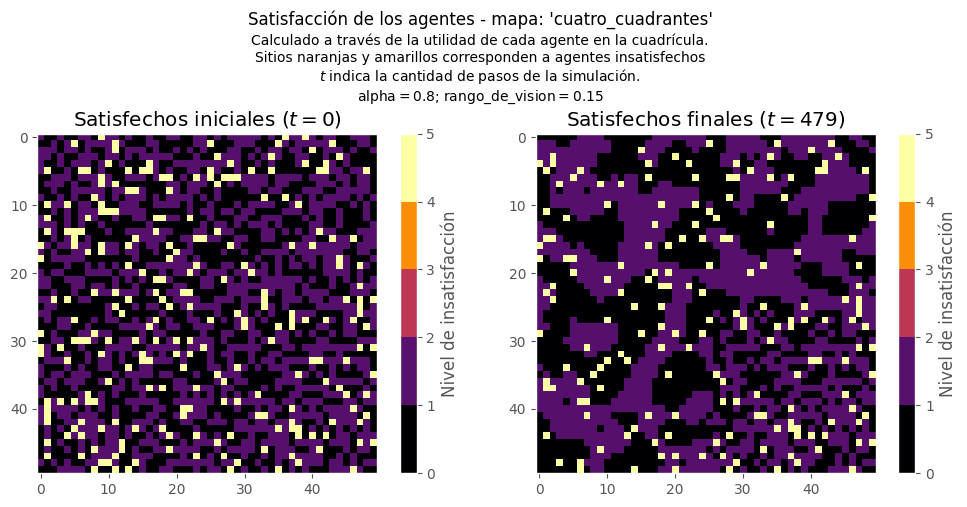

In [11]:
mostrar_satisfechos_antes_despues(satisfechos_inicial, satisfechos_final, 
                                  **opciones_graficas_antes_despues_cuatro_cuadrantes)

---
## Cambiando el rango de visión

In [12]:
rng = random_number_generator(seed=42069)

caching_actions = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
)

alphas = [.1,.4,.8]

subdivisiones = 10
rangos_de_vision = np.linspace(0,1, subdivisiones)

M = len(alphas) * len(rangos_de_vision)
N = cuatro_cuadrantes.mapa.shape[0]
start_max = 10
escala = plt.Normalize(0, 2*start_max)
config_iniciales = rng.uniform(0, start_max, (M, N, N)) # M matrices de N x N

i = 0
inputs = []
for alpha in tqdm(alphas):
    for r in rangos_de_vision:
        inputs.append((alpha, r, rng, cuatro_cuadrantes, config_iniciales[i], SimuladorFactory(criterio_equilibrio=criterio_equilibrio, max_steps=150, lag=20, tol=1e-3, on_finish_print=False, cache_actions=caching_actions)))
        i += 1

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
simuladores = Storage()
create_os_buttons(detect_os(), opciones_ejecutar_modelo(inputs, simuladores))

# If all else fails...

# simuladores.set_store(correr_secuencialmente(inputs)) # correr con un solo hilo
# simuladores.set_store(correr_en_paralelo(inputs)) # correr en paralelo

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
try:
    simuladores = simuladores.get_store()
except AttributeError:
    if isinstance(simuladores, list):
        pass

In [20]:
resultados = [
    s.export(
        observaciones = observaciones_de,
        alpha = alpha_del_modelo,
        rango = rango_del_modelo,
        gini_tk = gini_capital_modelo,
        gini_tu = gini_utilidad_modelo,
        ginis_k = gini_capital_por_barrio,
        ginis_u = gini_utilidad_por_barrio,
        satisfechos = satisfechos_por_barrio,
        pasos = cantidad_de_pasos)
    
    for s in simuladores
]

In [24]:
filename = generate_filename('cuatro_cuadrantes', start_max, alphas, subdivisiones, 1)
filename = non_colliding_name(filename)
json.dump(resultados, filename)

In [25]:
# resultados = json.load('./tp/data/resultados/cuadrantes_10_841_1000.json')

In [26]:
habitantes_por_barrio = [
    (cuatro_cuadrantes.mapa == i).sum()
    for i in range(4)
]

In [27]:
satisfechos = dict()

for cache in resultados:
    alpha = cache['alpha']
    rango = cache['rango']

    for s in cache['satisfechos']:
        satisfechos.setdefault(alpha, {}).setdefault(rango, []).append(s)

<Figure size 640x480 with 0 Axes>

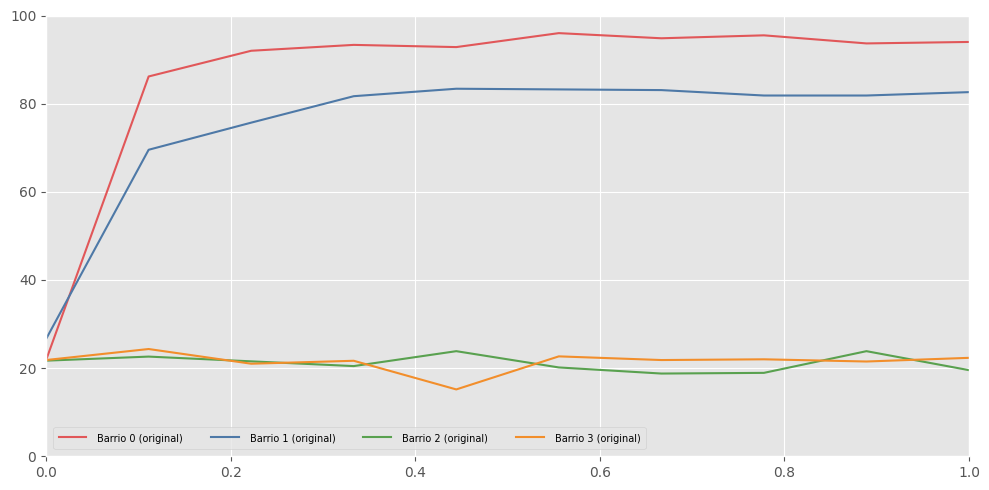

In [30]:
plt.clf()
plt.ion()
plot_satisfacciones_para_alpha(.1, satisfechos, habitantes_por_barrio, cuatro_cuadrantes.barrios_definidos);